# Connect Eye-AI and Load Libraries

In [1]:
%load_ext autoreload
%autoreload 2

# # Update the load path so python can find modules for the model
import sys
from pathlib import Path
sys.path.insert(0, str(Path.home() / "eye-ai-ml"))
sys.path.insert(0, str(Path.home() / "eye-ai-exec"))

In [2]:
# Prerequisites
import json
import os
from PIL import Image

# EyeAI, Deriva, VGG19
from deriva_ml import DatasetSpec, DatasetBag, Workflow, ExecutionConfiguration, VersionPart
from deriva_ml import MLVocab as vc
from eye_ai.eye_ai import EyeAI
from models.vgg19 import vgg19_diagnosis_train

# ML Analytics
import pandas as pd
import numpy as np
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Other Utilities
from pathlib import Path, PurePath
import logging
from datetime import datetime

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', force=True)

2025-06-18 17:44:47.213627: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-18 17:44:47.213681: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-18 17:44:47.214480: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-18 17:44:47.220510: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-18 17:44:48.000366: W tensorflow/compiler/tf2

In [3]:
# Login
from deriva.core.utils.globus_auth_utils import GlobusNativeLogin
host = 'www.eye-ai.org'
#host = 'dev.eye-ai.org' #for dev testing
catalog_id = "eye-ai"

gnl = GlobusNativeLogin(host=host)
if gnl.is_logged_in([host]):
    print("You are already logged in.")
else:
    gnl.login([host], no_local_server=True, no_browser=True, refresh_tokens=True, update_bdbag_keychain=True)
    print("Login Successful")

2025-06-18 17:44:48,641 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-06-18 17:44:48,642 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>


You are already logged in.


# Configuration

In [4]:
cache_dir = '/data'
working_dir = '/data'
EA = EyeAI(hostname = host, catalog_id = catalog_id, cache_dir= cache_dir, working_dir=working_dir)

2025-06-18 17:44:49,519 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-06-18 17:44:49,520 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>


In [5]:

#EA.increment_dataset_version(dataset_rid='4-YWKJ', component= VersionPart.patch, description='Update after annotations added')

In [6]:
source_dataset = "4-YWKJ" # USC test set
crop = True

if crop:
    asset_RID = ["4-MWQ6"]  # VGG19 cropped
else:
    asset_RID = ["4-MWQ8"]  # VGG19 uncropped

preds_workflow = EA.add_workflow( 
    Workflow(
        name="VGG Predictions by KB",
        url="https://github.com/informatics-isi-edu/eye-ai-exec/blob/main/notebooks/Sandbox_KB/VGG_Predict.ipynb",
        workflow_type="Test Workflow",
        )
    )

config = ExecutionConfiguration(
    datasets=[ DatasetSpec(rid=source_dataset, version=EA.dataset_version(source_dataset), materialize=True) ],
    assets=asset_RID,
    workflow=preds_workflow,
    description="Instance of creating VGG19 predictions: VGG19 Uncropped on 4-YWKJ USC Test",
    )

execution = EA.create_execution(config)

2025-06-18 17:44:52,052 - INFO - Materialize bag 4-YWKJ... 
2025-06-18 17:44:52,162 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-06-18 17:44:52,163 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>
2025-06-18 17:44:53,788 - INFO - Using cached bag for  4-YWKJ Version:0.2.0
2025-06-18 17:44:53,789 - INFO - Loading /data/4-YWKJ_44b67c208c639554dd582f1575a7466fd853affad87411a7f99d28c7559acbbb/Dataset_4-YWKJ
2025-06-18 17:44:54,227 - INFO - Creating new database for dataset: 4-YWKJ in /data/kb_766/EyeAI_working/4-YWKJ@33F-J5QX-5CCA.db
2025-06-18 17:44:54,276 - INFO - Downloading assets ...
2025-06-18 17:44:58,491 - INFO - File [/data/kb_766/EyeAI_working/deriva-ml/execution/4-YX7E/downloaded-assets/Execution_Asset/VGG19_FULL_Images_Cropped_2-277G_Feb_14_2025.h5] transfer successful. 227.

In [7]:
print(execution)

caching_dir: /data
_working_dir: /data/kb_766/EyeAI_working
execution_rid: 4-YX7E
workflow_rid: 4-YSP4
asset_paths: {'Execution_Asset': [AssetFilePath('/data/kb_766/EyeAI_working/deriva-ml/execution/4-YX7E/downloaded-assets/Execution_Asset/VGG19_FULL_Images_Cropped_2-277G_Feb_14_2025.h5')]}
configuration: datasets=[DatasetSpec(rid='4-YWKJ', materialize=True, version=DatasetVersion(major=0, minor=2, patch=0))] assets=['4-MWQ6'] workflow='4-YSP4' parameters={} description='Instance of creating VGG19 predictions: VGG19 Uncropped on 4-YWKJ USC Test' argv=['/home/kb_766/.conda/envs/my-tensorflow-conda/lib/python3.10/site-packages/ipykernel_launcher.py', '-f', '/home/kb_766/.local/share/jupyter/runtime/kernel-9df0d7de-d6f5-47ca-a76c-87e85401b2d8.json']


In [8]:
output_dir = execution._working_dir / execution.execution_rid

In [9]:
ds_bag_test = execution.datasets[0]

In [10]:
# FOR USC MULTIMODAL DATA
# Group files as glaucoma/not for VGG evaluation

imageDF = ds_bag_test.get_table_as_dataframe('Image')
annotation_bounding_box =  pd.merge( ds_bag_test.get_table_as_dataframe('Annotation')[['Image', 'Fundus_Bounding_Box']], 
                                                ds_bag_test.get_table_as_dataframe('Fundus_Bounding_Box'), 
                                                left_on='Fundus_Bounding_Box', 
                                                right_on='RID')

import shutil

output_path =  output_dir / "Test"
output_path.mkdir(parents=True, exist_ok=True)
    
output_path_suspected = output_path / "No_Glaucoma"
output_path_glaucoma = output_path / "Suspected_Glaucoma"
    
output_path_suspected.mkdir(parents=True, exist_ok=True)
output_path_glaucoma.mkdir(parents=True, exist_ok=True)

for index, row in imageDF.iterrows():     
    src_path = row["Filename"]
    image_rid = row["RID"]
    dest_name = row["RID"] + ".jpg"
    if crop:
        dest_name = "Crop_" + dest_name
    label = row["RID"].split( sep = "-" )[0]
    
    if label == "4":
        dest_path = os.path.join(output_path_suspected, dest_name)
    elif label == "2":
        dest_path = os.path.join(output_path_glaucoma, dest_name)
    else: 
        continue    
    
    if crop:
        image = Image.open(src_path)
        svg_path = annotation_bounding_box.loc[annotation_bounding_box['Image'] == image_rid, 'Filename'].values[0]
        svg_path = Path(svg_path)
        if not svg_path.exists():
          continue
        bbox = EA.get_bounding_box(svg_path)
        cropped_image = image.crop(bbox)
        cropped_image.save(dest_path)
    else:
        shutil.copy2(src_path, dest_path)

output_path

PosixPath('/data/kb_766/EyeAI_working/4-YX7E/Test')

In [11]:
!ls /data/kb_766/EyeAI_working/4-YX7E/Test

No_Glaucoma  Suspected_Glaucoma


In [12]:
!ls /data/kb_766/EyeAI_working/4-YX7E/Test/No_Glaucoma

Crop_4-YRP6.jpg  Crop_4-YRSW.jpg  Crop_4-YRYG.jpg  Crop_4-YS1W.jpg
Crop_4-YRPA.jpg  Crop_4-YRT2.jpg  Crop_4-YRYJ.jpg  Crop_4-YS1Y.jpg
Crop_4-YRPE.jpg  Crop_4-YRT6.jpg  Crop_4-YRYM.jpg  Crop_4-YS22.jpg
Crop_4-YRPG.jpg  Crop_4-YRT8.jpg  Crop_4-YRYP.jpg  Crop_4-YS24.jpg
Crop_4-YRPJ.jpg  Crop_4-YRTG.jpg  Crop_4-YRYR.jpg  Crop_4-YS28.jpg
Crop_4-YRPM.jpg  Crop_4-YRTJ.jpg  Crop_4-YRYW.jpg  Crop_4-YS2A.jpg
Crop_4-YRPT.jpg  Crop_4-YRTM.jpg  Crop_4-YRYY.jpg  Crop_4-YS2C.jpg
Crop_4-YRPW.jpg  Crop_4-YRTT.jpg  Crop_4-YRZ4.jpg  Crop_4-YS2G.jpg
Crop_4-YRPY.jpg  Crop_4-YRTW.jpg  Crop_4-YRZ6.jpg  Crop_4-YS2P.jpg
Crop_4-YRQ0.jpg  Crop_4-YRTY.jpg  Crop_4-YRZA.jpg  Crop_4-YS2R.jpg
Crop_4-YRQ6.jpg  Crop_4-YRV2.jpg  Crop_4-YRZC.jpg  Crop_4-YS2T.jpg
Crop_4-YRQ8.jpg  Crop_4-YRV4.jpg  Crop_4-YRZE.jpg  Crop_4-YS2W.jpg
Crop_4-YRQC.jpg  Crop_4-YRV6.jpg  Crop_4-YRZJ.jpg  Crop_4-YS30.jpg
Crop_4-YRQE.jpg  Crop_4-YRV8.jpg  Crop_4-YRZM.jpg  Crop_4-YS32.jpg
Crop_4-YRQM.jpg  Crop_4-YRVJ.jpg  Crop_4-YRZP.jpg  Crop_4-YS36

In [13]:
!ls /data/kb_766/EyeAI_working/4-YX7E/Test/No_Glaucoma -1 | wc -l

150


In [14]:
!ls /data/kb_766/EyeAI_working/4-YX7E/Test/Suspected_Glaucoma

Crop_2-BDCW.jpg  Crop_2-BJS0.jpg  Crop_2-BR4T.jpg  Crop_2-BYD0.jpg
Crop_2-BDHR.jpg  Crop_2-BJTP.jpg  Crop_2-BRVJ.jpg  Crop_2-BYF0.jpg
Crop_2-BDQT.jpg  Crop_2-BK9M.jpg  Crop_2-BRXR.jpg  Crop_2-BYHP.jpg
Crop_2-BE6A.jpg  Crop_2-BKC6.jpg  Crop_2-BS4A.jpg  Crop_2-BYQJ.jpg
Crop_2-BE90.jpg  Crop_2-BKFW.jpg  Crop_2-BS7T.jpg  Crop_2-BYSP.jpg
Crop_2-BEA0.jpg  Crop_2-BKQJ.jpg  Crop_2-BSA0.jpg  Crop_2-BYSR.jpg
Crop_2-BEA4.jpg  Crop_2-BKSA.jpg  Crop_2-BSDM.jpg  Crop_2-BYXM.jpg
Crop_2-BEFY.jpg  Crop_2-BKSG.jpg  Crop_2-BSEJ.jpg  Crop_2-BYYC.jpg
Crop_2-BEQG.jpg  Crop_2-BKY2.jpg  Crop_2-BSN4.jpg  Crop_2-BZ00.jpg
Crop_2-BET6.jpg  Crop_2-BM18.jpg  Crop_2-BSQ8.jpg  Crop_2-BZP0.jpg
Crop_2-BFA8.jpg  Crop_2-BM9T.jpg  Crop_2-BSST.jpg  Crop_2-BZRT.jpg
Crop_2-BFDM.jpg  Crop_2-BMD6.jpg  Crop_2-BT0E.jpg  Crop_2-BZSC.jpg
Crop_2-BFK4.jpg  Crop_2-BMH2.jpg  Crop_2-BT3M.jpg  Crop_2-BZTW.jpg
Crop_2-BFNY.jpg  Crop_2-BMJ8.jpg  Crop_2-BT84.jpg  Crop_2-C05W.jpg
Crop_2-BFYA.jpg  Crop_2-BMJC.jpg  Crop_2-BTB8.jpg  Crop_2-C08E

In [15]:
!ls /data/kb_766/EyeAI_working/4-YX7E/Test/Suspected_Glaucoma -1 | wc -l

150


In [16]:
asset_output_dir = execution._working_dir / execution.execution_rid / "asset"
asset_output_dir.mkdir( parents=True, exist_ok=True )

In [17]:
current_date = datetime.now().strftime("%b_%d_%Y") 

In [18]:
model_path = str(execution.asset_paths['Execution_Asset'][0])

In [19]:

with execution.execute() as exec:
        predictions_results, metrics_summary = vgg19_diagnosis_train.evaluate_only(
            model_path = model_path, 
            model_name = f"VGG19_Cropped_Model_{ds_bag_test.dataset_rid}_{current_date}", 
            test_path = output_path, 
            output_dir = asset_output_dir,
            classes = {'No_Glaucoma': 0, 'Suspected_Glaucoma': 1}
        )
        print("Execution Results:")
        print(predictions_results, metrics_summary)

2025-06-18 17:46:15,347 - INFO - Start execution  ...
2025-06-18 17:46:15,441 - INFO - Start execution  ...
2025-06-18 17:46:15.666852: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-18 17:46:15.695279: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-18 17:46:15.698917: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node

Found 300 images belonging to 2 classes.


2025-06-18 17:46:17.080763: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-06-18 17:46:23,527 - INFO - Predictions saved to VGG19_Cropped_Model_4-YWKJ_Jun_18_2025_predictions_results.csv
2025-06-18 17:46:23,528 - INFO - Metrics saved to VGG19_Cropped_Model_4-YWKJ_Jun_18_2025_metrics_summary.csv
2025-06-18 17:46:23,529 - INFO - Successfully run Ml.
2025-06-18 17:46:23,600 - INFO - Algorithm execution ended.


Execution Results:
/data/kb_766/EyeAI_working/4-YX7E/asset/VGG19_Cropped_Model_4-YWKJ_Jun_18_2025_predictions_results.csv /data/kb_766/EyeAI_working/4-YX7E/asset/VGG19_Cropped_Model_4-YWKJ_Jun_18_2025_metrics_summary.csv


In [20]:
pd.read_csv( metrics_summary )

,Metric,Value
0,F1 Score,0.681690
1,Precision,0.590244
2,Recall,0.806667
3,Accuracy,0.623333
4,ROC-AUC,0.767333


In [22]:
preds = pd.read_csv( predictions_results )

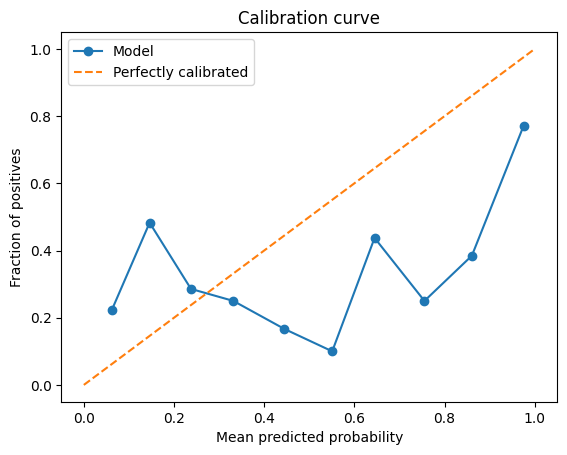

In [23]:
# Calibration curve
prob_true, prob_pred = calibration_curve( preds["True Label"], preds["Probability Score"], n_bins=10, strategy='uniform')
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.show()

# Upload Results

In [118]:
# # crete asset path
# asset_type_name = "Diagnosis_Analysis"
# asset_path = exec.execution_asset_path(asset_type_name)

# # save assets to asset_path
# linkdDF.to_csv(asset_path/'ImagesToVGG19.csv', index=False)

# upload assets to catalog
exec.upload_execution_outputs(clean_folder=True)

2025-03-24 16:16:09,766 - INFO - Initializing uploader: GenericUploader v1.7.6 [Python 3.10.13, Linux-5.10.210-201.852.amzn2.x86_64-x86_64-with-glibc2.26]
2025-03-24 16:16:09,767 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-03-24 16:16:09,767 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>
2025-03-24 16:16:09,804 - INFO - Scanning files in directory [/home/kb_766/deriva-ml/DerivaML_working/deriva-ml/execution/4-S42C]...
2025-03-24 16:16:09,805 - INFO - Including file: [/home/kb_766/deriva-ml/DerivaML_working/deriva-ml/execution/4-S42C/execution-metadata/Execution_Config/configuration.json].
2025-03-24 16:16:09,806 - INFO - Including file: [/home/kb_766/deriva-ml/DerivaML_working/deriva-ml/execution/4-S42C/execution-metadata/Runtime_Env/environment_snapshot_ytvbrm53.txt].
2025-03-24

{'Execution_Config/configuration.json': FileUploadState(state=<UploadState.success: 0>, status='Complete', result={'URL': '/hatrac/execution_metadata/c574c9dbd4d2f1c98a1120b20c9c2b3a.configuration.json:dzyDIqTmdshSDmojKAIzT8JYnBDH1Mdx', 'RID': '4-S4R0', 'RCT': '2025-03-24T23:16:10.356903+00:00', 'RMT': '2025-03-24T23:16:10.356903+00:00', 'RCB': 'https://auth.globus.org/6022643c-876c-4a47-bafa-5b9fac2c7782', 'RMB': 'https://auth.globus.org/6022643c-876c-4a47-bafa-5b9fac2c7782', 'Filename': 'configuration.json', 'Description': None, 'Length': 226, 'MD5': 'c574c9dbd4d2f1c98a1120b20c9c2b3a', 'Execution_Metadata_Type': 'Execution_Config'}, rid='4-S4R0'),
 'Runtime_Env/environment_snapshot_ytvbrm53.txt': FileUploadState(state=<UploadState.success: 0>, status='Complete', result={'URL': '/hatrac/execution_metadata/4bdd399d7cc638e1bb0e992d330c240b.environment_snapshot_ytvbrm53.txt:yPxwkhgeO6Ub5AcWr6kVDY8hvXhRfPpx', 'RID': '4-S4R2', 'RCT': '2025-03-24T23:16:10.635156+00:00', 'RMT': '2025-03-24T2